Import and Set up

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import copy
import matplotlib.pyplot as plt
import os # For Colab path handling

# Check for GPU availability and set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


Connect to Google Dirve

In [2]:
# Cell 1.5: Mount Google Drive and Ensure Directories
from google.colab import drive
# import os # Ensure os is imported

drive.mount('/content/drive')

# --- Define BASE paths for directories in your Google Drive ---
DRIVE_PROJECT_BASE = '/content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation'
MODELS_DIR_PATH = os.path.join(DRIVE_PROJECT_BASE, 'models')
RESULTS_DIR_PATH = os.path.join(DRIVE_PROJECT_BASE, 'results')

# --- Ensure the target directories exist in Drive ---
for path_to_check in [MODELS_DIR_PATH, RESULTS_DIR_PATH]:
    try:
        os.makedirs(path_to_check, exist_ok=True)
        print(f"Directory ensured at: {path_to_check}")
    except OSError as e:
        print(f"Error creating directory {path_to_check}: {e}")
        # Provide more context if needed
    except Exception as e:
         print(f"An unexpected error occurred while checking/creating {path_to_check}: {e}")

Mounted at /content/drive
Directory ensured at: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models
Directory ensured at: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results


Hyperparameters and Configuration (Original)

In [3]:
# Configuration based on typical ResNet training on CIFAR-10
BATCH_SIZE = 128
LEARNING_RATE = 0.1 # Initial learning rate for SGD
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4 # L2 regularization
EPOCHS = 100 # Adjust as needed, Self-Distillation might converge differently
NUM_CLASSES = 10 # CIFAR-10 has 10 classes

# Learning Rate Scheduler Milestones
LR_MILESTONES = [int(EPOCHS * 0.5), int(EPOCHS * 0.75)] # Adjust if EPOCHS change significantly
LR_GAMMA = 0.1 # Factor to reduce LR by

# --- Self-Distillation Hyperparameters ---
TEMPERATURE = 3.0 # Temperature for softening probabilities
W_AUX_CE = 0.4   # Weight for auxiliary classifier Cross-Entropy losses
W_KD = 0.6     # Weight for Knowledge Distillation (KL Div) losses


# --- Define Model and Plot Filenames ---
MODEL_FILENAME = f'resnet50_self_distill_T{TEMPERATURE}_Waux{W_AUX_CE}_Wkd{W_KD}.pth' # <<< Updated filename with SD params
PLOT_FILENAME = f'resnet50_self_distill_T{TEMPERATURE}_Waux{W_AUX_CE}_Wkd{W_KD}_curves.png' # <<< Updated filename

# --- Construct full paths using variables from Cell 1.5 ---
MODEL_SAVE_PATH = os.path.join(MODELS_DIR_PATH, MODEL_FILENAME)
PLOT_SAVE_PATH = os.path.join(RESULTS_DIR_PATH, PLOT_FILENAME)

print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Initial Learning Rate: {LEARNING_RATE}")
print(f"LR Milestones: {LR_MILESTONES}")
print(f"Temperature (T): {TEMPERATURE}")
print(f"Aux CE Loss Weight: {W_AUX_CE}")
print(f"KD Loss Weight: {W_KD}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")
print(f"Plot will be saved to: {PLOT_SAVE_PATH}")

Epochs: 100
Batch Size: 128
Initial Learning Rate: 0.1
LR Milestones: [50, 75]
Temperature (T): 3.0
Aux CE Loss Weight: 0.4
KD Loss Weight: 0.6
Model will be saved to: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6.pth
Plot will be saved to: /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6_curves.png


Data Loading and Transforming

In [4]:
print("Setting up CIFAR-10 data transformations...")
# Normalization values for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

print("Loading CIFAR-10 dataset...")
# Use /content/data for Colab storage
trainset = torchvision.datasets.CIFAR10(
    root='/content/data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='/content/data', train=False, download=True, transform=transform_test)
testloader = DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print("Dataset loaded.")
print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")

Setting up CIFAR-10 data transformations...
Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


Dataset loaded.
Training set size: 50000
Test set size: 10000


Model Definition (ResNet-50 Baseline)

In [5]:
print("Defining ResNet-50 model with auxiliary classifiers for Self-Distillation...")

# Load ResNet-50 architecture.
# We'll use its layers but define a custom forward pass.
base_model = torchvision.models.resnet50(weights=None) # Start with random weights

class ResNet50_SD(nn.Module):
    def __init__(self, base_model, num_classes=10):
        super(ResNet50_SD, self).__init__()
        # Use layers from the base ResNet-50
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        self.avgpool = base_model.avgpool

        # Original final classifier (Teacher / Final Output)
        self.fc_final = nn.Linear(base_model.fc.in_features, num_classes)

        # --- Add Auxiliary Classifiers ---
        # After layer 2 (ResNet-50 layer2 output channels: 512)
        self.avgpool_aux2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_aux2 = nn.Linear(512, num_classes)

        # After layer 3 (ResNet-50 layer3 output channels: 1024)
        self.avgpool_aux3 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_aux3 = nn.Linear(1024, num_classes)

        print("Auxiliary classifiers added after layer2 and layer3.")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        out_layer2 = self.layer2(x) # Output after layer 2

        # Auxiliary Classifier 2 Path
        aux2 = self.avgpool_aux2(out_layer2)
        aux2 = torch.flatten(aux2, 1)
        out_aux2 = self.fc_aux2(aux2)

        out_layer3 = self.layer3(out_layer2) # Output after layer 3

        # Auxiliary Classifier 3 Path
        aux3 = self.avgpool_aux3(out_layer3)
        aux3 = torch.flatten(aux3, 1)
        out_aux3 = self.fc_aux3(aux3)

        out_layer4 = self.layer4(out_layer3) # Output after layer 4 (final features)

        # Final Classifier Path
        final = self.avgpool(out_layer4)
        final = torch.flatten(final, 1)
        out_final = self.fc_final(final)

        # Return all relevant outputs for training
        return out_final, out_aux2, out_aux3

# Instantiate the SD model
model = ResNet50_SD(base_model, num_classes=NUM_CLASSES)
print("ResNet-50 Self-Distillation model defined.")

Defining ResNet-50 model with auxiliary classifiers for Self-Distillation...
Auxiliary classifiers added after layer2 and layer3.
ResNet-50 Self-Distillation model defined.


Cell 5: Instantiate Model, Loss, Optimizer, Scheduler (Add KLDivLoss)

In [6]:
print("Instantiating ResNet-50_SD model...")
# model is already defined and instantiated in Cell 4

model = model.to(DEVICE) # Move model defined in Cell 4 to the device
print("Model instantiated and moved to device.")

# Standard Loss Function (for final and auxiliary CE)
criterion_ce = nn.CrossEntropyLoss()
print("Loss function (CE): CrossEntropyLoss")

# Distillation Loss Function (KL Divergence)
# reduction='batchmean' averages the loss per batch *before* dividing by N.
# Use reduction='mean' if you want loss averaged over all elements. 'batchmean' is common for KD.
criterion_kd = nn.KLDivLoss(reduction='batchmean')
print("Loss function (KD): KLDivLoss (reduction='batchmean')")


# Optimizer (SGD is standard for ResNets on CIFAR)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
print(f"Optimizer: SGD (LR={LEARNING_RATE}, Momentum={MOMENTUM}, WD={WEIGHT_DECAY})")

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=LR_MILESTONES, gamma=LR_GAMMA)
print(f"LR Scheduler: MultiStepLR (milestones={LR_MILESTONES}, gamma={LR_GAMMA})")

Instantiating ResNet-50_SD model...
Model instantiated and moved to device.
Loss function (CE): CrossEntropyLoss
Loss function (KD): KLDivLoss (reduction='batchmean')
Optimizer: SGD (LR=0.1, Momentum=0.9, WD=0.0005)
LR Scheduler: MultiStepLR (milestones=[50, 75], gamma=0.1)


Training and Validation Functions

In [7]:
def train_one_epoch_sd(epoch, model, trainloader, optimizer, criterion_ce, criterion_kd, device, temp, w_aux_ce, w_kd):
    model.train() # Set model to training mode
    running_loss = 0.0
    running_loss_final_ce = 0.0
    running_loss_aux_ce = 0.0
    running_loss_kd = 0.0
    correct_final = 0 # Track accuracy only based on the final classifier
    total = 0
    start_time = time.time()
    print_freq = len(trainloader) // 4 # Print progress roughly 4 times per epoch

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass - get all outputs
        out_final, out_aux2, out_aux3 = model(inputs)

        # --- Calculate Loss Components ---
        # 1. Final Classifier Cross-Entropy Loss
        loss_final_ce = criterion_ce(out_final, labels)

        # 2. Auxiliary Classifiers Cross-Entropy Loss
        loss_aux2_ce = criterion_ce(out_aux2, labels)
        loss_aux3_ce = criterion_ce(out_aux3, labels)
        loss_aux_ce_total = loss_aux2_ce + loss_aux3_ce

        # 3. Knowledge Distillation Loss (Final teaches Aux)
        # Use log_softmax for student predictions and softmax for teacher predictions
        # Teacher predictions should be detached from the graph
        teacher_prob = F.softmax(out_final / temp, dim=1).detach()

        loss_kd2 = criterion_kd(
            F.log_softmax(out_aux2 / temp, dim=1),
            teacher_prob
        ) * (temp * temp) # Scaling factor, common practice for KLDiv with temperature

        loss_kd3 = criterion_kd(
            F.log_softmax(out_aux3 / temp, dim=1),
            teacher_prob
        ) * (temp * temp) # Scaling factor

        loss_kd_total = loss_kd2 + loss_kd3

        # --- Calculate Total Weighted Loss ---
        total_loss = loss_final_ce + w_aux_ce * loss_aux_ce_total + w_kd * loss_kd_total

        # Backward + optimize
        total_loss.backward()
        optimizer.step()

        # --- Statistics ---
        running_loss += total_loss.item()
        running_loss_final_ce += loss_final_ce.item()
        running_loss_aux_ce += loss_aux_ce_total.item()
        running_loss_kd += loss_kd_total.item()

        # Accuracy is calculated ONLY based on the final classifier's output
        _, predicted_final = torch.max(out_final.data, 1)
        total += labels.size(0)
        correct_final += (predicted_final == labels).sum().item()

        # Print progress
        if (i + 1) % print_freq == 0 or (i + 1) == len(trainloader):
             print(f'Epoch [{epoch + 1}/{EPOCHS}], Step [{i + 1}/{len(trainloader)}], '
                   f'Loss: {running_loss / (i + 1):.4f} '
                   f'(FinalCE: {running_loss_final_ce / (i + 1):.4f}, '
                   f'AuxCE: {running_loss_aux_ce / (i + 1):.4f}, '
                   f'KD: {running_loss_kd / (i + 1):.4f})')

    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(trainloader)
    epoch_acc_final = 100. * correct_final / total # Report accuracy based on final layer
    print(f'---> Epoch {epoch + 1} Training Summary: Avg Loss: {epoch_loss:.4f}, Final Acc: {epoch_acc_final:.2f}%, Time: {epoch_time:.2f}s')
    # Return avg total loss and final accuracy for history tracking
    return epoch_loss, epoch_acc_final

# --- Validation Function ---
# IMPORTANT: Validation uses ONLY the final output, standard CE Loss
def validate_sd(model, testloader, criterion_ce, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad(): # No need to track gradients during validation
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # --- Get ONLY the final output for validation ---
            outputs_final, _, _ = model(images) # Ignore auxiliary outputs

            loss = criterion_ce(outputs_final, labels) # Use standard CE loss

            running_loss += loss.item()
            _, predicted = torch.max(outputs_final.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_time = time.time() - start_time
    val_loss = running_loss / len(testloader)
    val_acc = 100. * correct / total
    print(f'---> Validation Summary (using final output): Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s')
    # Return validation loss and accuracy based on final layer
    return val_loss, val_acc

print("Self-Distillation training and validation functions defined.")

Self-Distillation training and validation functions defined.


Hyperparameter Set 1:

T=2.0

AUX weight=0.4

KL weight=0.6

In [8]:
# --- Self-Distillation Hyperparameters ---
TEMPERATURE = 3.0 # Temperature for softening probabilities
W_AUX_CE = 0.4   # Weight for auxiliary classifier Cross-Entropy losses
W_KD = 0.6     # Weight for Knowledge Distillation (KL Div) losses

Training Loop 1

In [11]:
print(f"Starting Self-Distillation Training for {EPOCHS} epochs...")
start_train_time = time.time()

best_val_acc = 0.0
# No need to initialize best_model_wts here, just save directly

# History tracking for plots (tracking total train loss and final val acc)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
    history['lr'].append(current_lr)

    # Train for one epoch using the Self-Distillation training function
    # Pass the extra hyperparameters (temp, w_aux_ce, w_kd)
    train_loss, train_acc = train_one_epoch_sd(
        epoch, model, trainloader, optimizer, criterion_ce, criterion_kd, DEVICE,
        TEMPERATURE, W_AUX_CE, W_KD
    )

    # Validate the model using the Self-Distillation validation function
    val_loss, val_acc = validate_sd(model, testloader, criterion_ce, DEVICE)

    # Store history (Train loss is total loss, Acc is based on final layer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc) # Final layer train acc
    history['val_loss'].append(val_loss)   # Final layer val loss
    history['val_acc'].append(val_acc)     # Final layer val acc

    # Update learning rate using the scheduler
    scheduler.step()

    # Save the best model based on validation accuracy (measured on final layer)
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_val_acc = val_acc
        # Save the model state dict directly to the path defined in Cell 2
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
        except Exception as e:
            print(f"Error saving model to {MODEL_SAVE_PATH}: {e}")


total_train_time = time.time() - start_train_time
print("\nFinished Self-Distillation Training.")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Accuracy achieved (on final layer): {best_val_acc:.2f}%")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

Starting Self-Distillation Training for 100 epochs...

--- Epoch 1/100 ---
Current Learning Rate: 0.100000
Epoch [1/100], Step [97/391], Loss: 34.1077 (FinalCE: 11.5669, AuxCE: 14.0088, KD: 28.2287)
Epoch [1/100], Step [194/391], Loss: 19.9399 (FinalCE: 7.4014, AuxCE: 9.4414, KD: 14.6032)
Epoch [1/100], Step [291/391], Loss: 14.8061 (FinalCE: 5.7758, AuxCE: 7.8247, KD: 9.8340)
Epoch [1/100], Step [388/391], Loss: 12.1818 (FinalCE: 4.9258, AuxCE: 7.0082, KD: 7.4211)
Epoch [1/100], Step [391/391], Loss: 12.1205 (FinalCE: 4.9059, AuxCE: 6.9895, KD: 7.3647)
---> Epoch 1 Training Summary: Avg Loss: 12.1205, Final Acc: 10.18%, Time: 35.43s
---> Validation Summary (using final output): Loss: 2.3078, Acc: 10.14%, Time: 2.90s
Validation accuracy improved (0.00% -> 10.14%). Saving model...
Model saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6.pth

--- Epoch 2/100 ---
Current Learning Rate: 0.1

Plotting Results 1


Plotting training history...
Plot saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6_curves.png


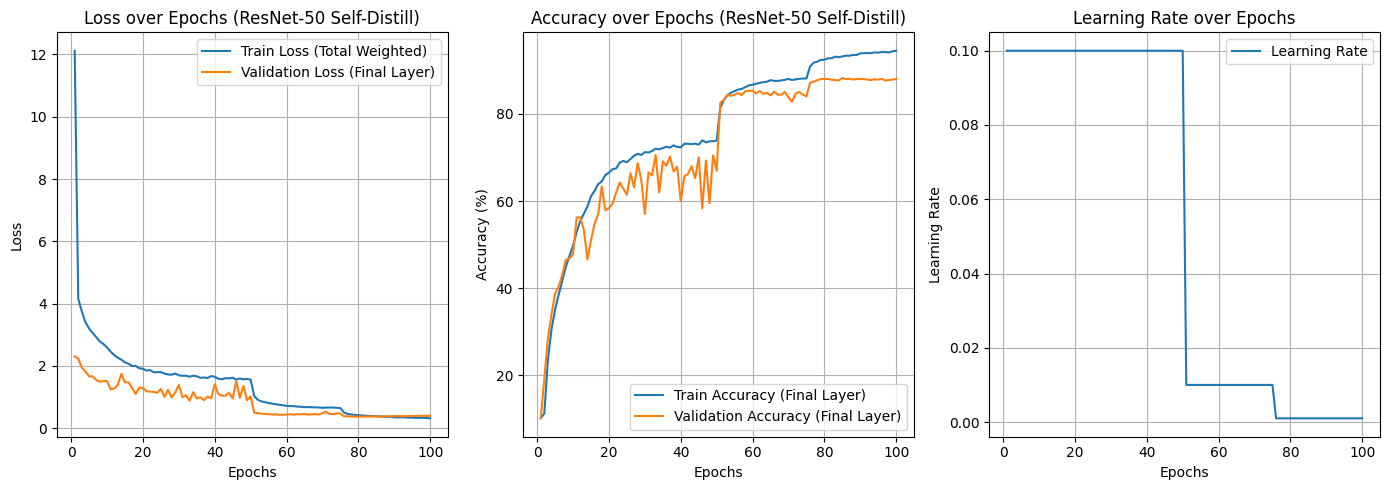

In [12]:
print("\nPlotting training history...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot Loss (Displays total weighted training loss vs final layer validation loss)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss (Total Weighted)')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss (Final Layer)')
plt.title('Loss over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy (Displays final layer training accuracy vs final layer validation accuracy)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy (Final Layer)')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy (Final Layer)')
plt.title('Accuracy over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot using the path defined in Cell 2
try:
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved to {PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot to {PLOT_SAVE_PATH}: {e}")

plt.show()

Final Test with Best Model 1

In [13]:
print("\nEvaluating the best self-distillation model on the test set...")

# --- Instantiate the ResNet50_SD architecture again ---
# Important: Instantiate the *same* custom model used for training
base_model_for_eval = torchvision.models.resnet50(weights=None) # Need the base structure again
best_model = ResNet50_SD(base_model_for_eval, num_classes=NUM_CLASSES)
# --- End of instantiation ---

try:
    # Load the best model weights saved during training (using path from Cell 2)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    best_model.to(DEVICE)
    print("Best self-distillation model weights loaded successfully.")

    # Perform final validation using the loaded best model
    # Use the specific validation function that only evaluates the final output
    final_loss, final_acc = validate_sd(best_model, testloader, criterion_ce, DEVICE)
    print(f"\nFinal Test Accuracy of the best ResNet-50 Self-Distillation model: {final_acc:.2f}%")

    # --- Compare with baseline ---
    baseline_acc = 87.68 # <-- Paste your baseline accuracy here
    print(f"Baseline ResNet-50 Test Accuracy: {baseline_acc:.2f}%")
    improvement = final_acc - baseline_acc
    print(f"Improvement due to Self-Distillation: {improvement:.2f}%")


except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Ensure training completed and saved the file.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Evaluating the best self-distillation model on the test set...
Auxiliary classifiers added after layer2 and layer3.
Best self-distillation model weights loaded successfully.
---> Validation Summary (using final output): Loss: 0.3747, Acc: 88.23%, Time: 4.34s

Final Test Accuracy of the best ResNet-50 Self-Distillation model: 88.23%
Baseline ResNet-50 Test Accuracy: 87.68%
Improvement due to Self-Distillation: 0.55%


Hyperparameter Set 2:

T=5.0

AUX weight=0.4

KL weight=0.6

In [8]:
# --- Self-Distillation Hyperparameters ---
TEMPERATURE = 5.0 # Temperature for softening probabilities
W_AUX_CE = 0.4   # Weight for auxiliary classifier Cross-Entropy losses
W_KD = 0.6     # Weight for Knowledge Distillation (KL Div) losses

Training Loop 2

In [9]:
print(f"Starting Self-Distillation Training for {EPOCHS} epochs...")
start_train_time = time.time()

best_val_acc = 0.0
# No need to initialize best_model_wts here, just save directly

# History tracking for plots (tracking total train loss and final val acc)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
    history['lr'].append(current_lr)

    # Train for one epoch using the Self-Distillation training function
    # Pass the extra hyperparameters (temp, w_aux_ce, w_kd)
    train_loss, train_acc = train_one_epoch_sd(
        epoch, model, trainloader, optimizer, criterion_ce, criterion_kd, DEVICE,
        TEMPERATURE, W_AUX_CE, W_KD
    )

    # Validate the model using the Self-Distillation validation function
    val_loss, val_acc = validate_sd(model, testloader, criterion_ce, DEVICE)

    # Store history (Train loss is total loss, Acc is based on final layer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc) # Final layer train acc
    history['val_loss'].append(val_loss)   # Final layer val loss
    history['val_acc'].append(val_acc)     # Final layer val acc

    # Update learning rate using the scheduler
    scheduler.step()

    # Save the best model based on validation accuracy (measured on final layer)
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_val_acc = val_acc
        # Save the model state dict directly to the path defined in Cell 2
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
        except Exception as e:
            print(f"Error saving model to {MODEL_SAVE_PATH}: {e}")


total_train_time = time.time() - start_train_time
print("\nFinished Self-Distillation Training.")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Accuracy achieved (on final layer): {best_val_acc:.2f}%")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

Starting Self-Distillation Training for 100 epochs...

--- Epoch 1/100 ---
Current Learning Rate: 0.100000
Epoch [1/100], Step [97/391], Loss: 44.3738 (FinalCE: 12.0957, AuxCE: 13.9669, KD: 44.4855)
Epoch [1/100], Step [194/391], Loss: 25.0173 (FinalCE: 7.6042, AuxCE: 9.3304, KD: 22.8015)
Epoch [1/100], Step [291/391], Loss: 18.2662 (FinalCE: 5.9203, AuxCE: 7.7597, KD: 15.4034)
Epoch [1/100], Step [388/391], Loss: 14.7989 (FinalCE: 5.0338, AuxCE: 6.9713, KD: 11.6277)
Epoch [1/100], Step [391/391], Loss: 14.7186 (FinalCE: 5.0132, AuxCE: 6.9529, KD: 11.5404)
---> Epoch 1 Training Summary: Avg Loss: 14.7186, Final Acc: 9.97%, Time: 32.39s
---> Validation Summary (using final output): Loss: 2.3048, Acc: 10.00%, Time: 2.94s
Validation accuracy improved (0.00% -> 10.00%). Saving model...
Model saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6.pth

--- Epoch 2/100 ---
Current Learning Rate: 0

Plotting 2


Plotting training history...
Plot saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6_curves.png


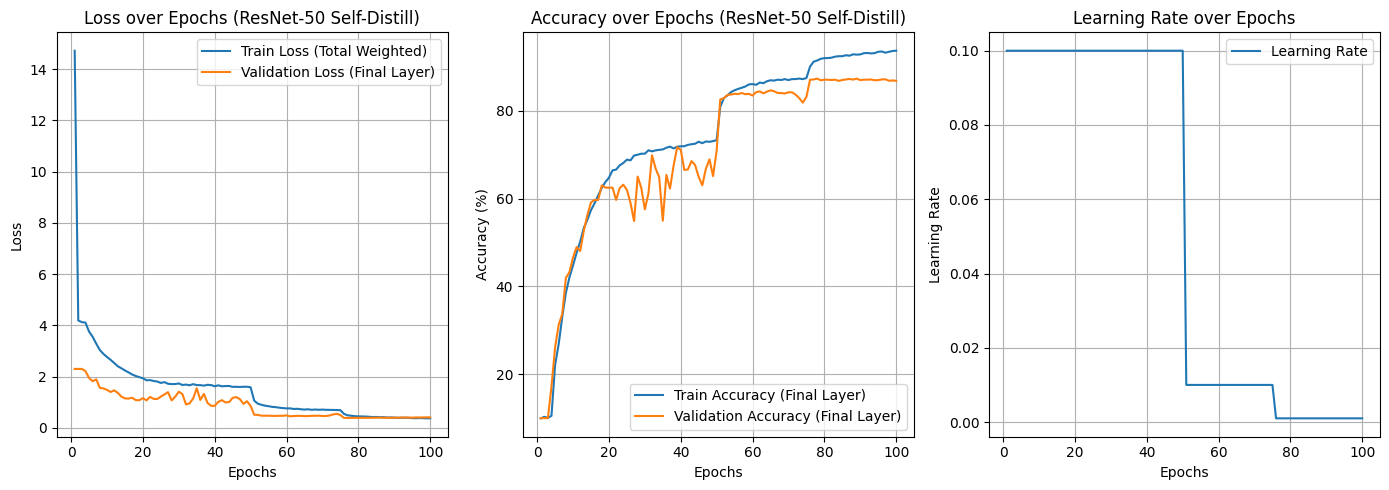

In [10]:
print("\nPlotting training history...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot Loss (Displays total weighted training loss vs final layer validation loss)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss (Total Weighted)')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss (Final Layer)')
plt.title('Loss over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy (Displays final layer training accuracy vs final layer validation accuracy)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy (Final Layer)')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy (Final Layer)')
plt.title('Accuracy over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot using the path defined in Cell 2
try:
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved to {PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot to {PLOT_SAVE_PATH}: {e}")

plt.show()

Final Test with Best Model 2

In [11]:
print("\nEvaluating the best self-distillation model on the test set...")

# --- Instantiate the ResNet50_SD architecture again ---
# Important: Instantiate the *same* custom model used for training
base_model_for_eval = torchvision.models.resnet50(weights=None) # Need the base structure again
best_model = ResNet50_SD(base_model_for_eval, num_classes=NUM_CLASSES)
# --- End of instantiation ---

try:
    # Load the best model weights saved during training (using path from Cell 2)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    best_model.to(DEVICE)
    print("Best self-distillation model weights loaded successfully.")

    # Perform final validation using the loaded best model
    # Use the specific validation function that only evaluates the final output
    final_loss, final_acc = validate_sd(best_model, testloader, criterion_ce, DEVICE)
    print(f"\nFinal Test Accuracy of the best ResNet-50 Self-Distillation model: {final_acc:.2f}%")

    # --- Compare with baseline ---
    baseline_acc = 87.68 # <-- Paste your baseline accuracy here
    print(f"Baseline ResNet-50 Test Accuracy: {baseline_acc:.2f}%")
    improvement = final_acc - baseline_acc
    print(f"Improvement due to Self-Distillation: {improvement:.2f}%")


except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Ensure training completed and saved the file.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Evaluating the best self-distillation model on the test set...
Auxiliary classifiers added after layer2 and layer3.
Best self-distillation model weights loaded successfully.
---> Validation Summary (using final output): Loss: 0.3927, Acc: 87.31%, Time: 2.67s

Final Test Accuracy of the best ResNet-50 Self-Distillation model: 87.31%
Baseline ResNet-50 Test Accuracy: 87.68%
Improvement due to Self-Distillation: -0.37%


Hyperparameter Set 3:

T=3.0

AUX weight=0.3

KL weight=0.7

In [12]:
# --- Self-Distillation Hyperparameters ---
TEMPERATURE = 3.0 # Temperature for softening probabilities
W_AUX_CE = 0.3   # Weight for auxiliary classifier Cross-Entropy losses
W_KD = 0.7     # Weight for Knowledge Distillation (KL Div) losses

Training Loop 3

In [13]:
print(f"Starting Self-Distillation Training for {EPOCHS} epochs...")
start_train_time = time.time()

best_val_acc = 0.0
# No need to initialize best_model_wts here, just save directly

# History tracking for plots (tracking total train loss and final val acc)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
    history['lr'].append(current_lr)

    # Train for one epoch using the Self-Distillation training function
    # Pass the extra hyperparameters (temp, w_aux_ce, w_kd)
    train_loss, train_acc = train_one_epoch_sd(
        epoch, model, trainloader, optimizer, criterion_ce, criterion_kd, DEVICE,
        TEMPERATURE, W_AUX_CE, W_KD
    )

    # Validate the model using the Self-Distillation validation function
    val_loss, val_acc = validate_sd(model, testloader, criterion_ce, DEVICE)

    # Store history (Train loss is total loss, Acc is based on final layer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc) # Final layer train acc
    history['val_loss'].append(val_loss)   # Final layer val loss
    history['val_acc'].append(val_acc)     # Final layer val acc

    # Update learning rate using the scheduler
    scheduler.step()

    # Save the best model based on validation accuracy (measured on final layer)
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_val_acc = val_acc
        # Save the model state dict directly to the path defined in Cell 2
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
        except Exception as e:
            print(f"Error saving model to {MODEL_SAVE_PATH}: {e}")


total_train_time = time.time() - start_train_time
print("\nFinished Self-Distillation Training.")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Accuracy achieved (on final layer): {best_val_acc:.2f}%")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

Starting Self-Distillation Training for 100 epochs...

--- Epoch 1/100 ---
Current Learning Rate: 0.001000
Epoch [1/100], Step [97/391], Loss: 0.3191 (FinalCE: 0.1812, AuxCE: 0.3600, KD: 0.0427)
Epoch [1/100], Step [194/391], Loss: 0.3268 (FinalCE: 0.1861, AuxCE: 0.3698, KD: 0.0426)
Epoch [1/100], Step [291/391], Loss: 0.3225 (FinalCE: 0.1832, AuxCE: 0.3655, KD: 0.0424)
Epoch [1/100], Step [388/391], Loss: 0.3271 (FinalCE: 0.1861, AuxCE: 0.3710, KD: 0.0424)
Epoch [1/100], Step [391/391], Loss: 0.3269 (FinalCE: 0.1860, AuxCE: 0.3707, KD: 0.0424)
---> Epoch 1 Training Summary: Avg Loss: 0.3269, Final Acc: 93.67%, Time: 29.07s
---> Validation Summary (using final output): Loss: 0.4169, Acc: 86.73%, Time: 2.87s
Validation accuracy improved (0.00% -> 86.73%). Saving model...
Model saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6.pth

--- Epoch 2/100 ---
Current Learning Rate: 0.001000
Epoc

Plotting 3


Plotting training history...
Plot saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6_curves.png


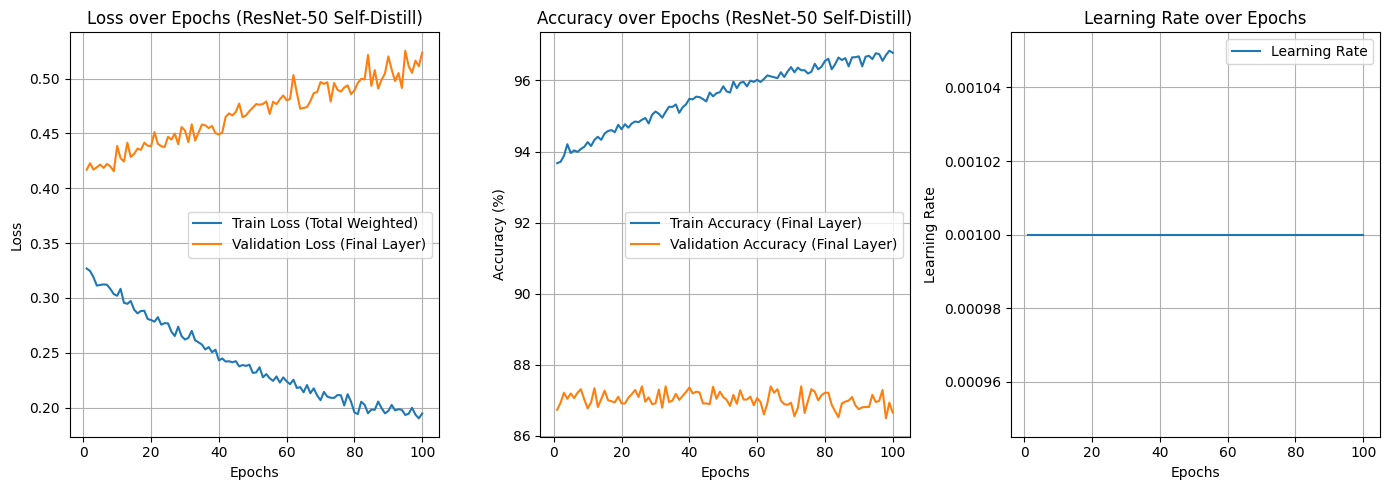

In [14]:
print("\nPlotting training history...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot Loss (Displays total weighted training loss vs final layer validation loss)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss (Total Weighted)')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss (Final Layer)')
plt.title('Loss over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy (Displays final layer training accuracy vs final layer validation accuracy)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy (Final Layer)')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy (Final Layer)')
plt.title('Accuracy over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot using the path defined in Cell 2
try:
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved to {PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot to {PLOT_SAVE_PATH}: {e}")

plt.show()

Final Test With Best Model 3

In [15]:
print("\nEvaluating the best self-distillation model on the test set...")

# --- Instantiate the ResNet50_SD architecture again ---
# Important: Instantiate the *same* custom model used for training
base_model_for_eval = torchvision.models.resnet50(weights=None) # Need the base structure again
best_model = ResNet50_SD(base_model_for_eval, num_classes=NUM_CLASSES)
# --- End of instantiation ---

try:
    # Load the best model weights saved during training (using path from Cell 2)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    best_model.to(DEVICE)
    print("Best self-distillation model weights loaded successfully.")

    # Perform final validation using the loaded best model
    # Use the specific validation function that only evaluates the final output
    final_loss, final_acc = validate_sd(best_model, testloader, criterion_ce, DEVICE)
    print(f"\nFinal Test Accuracy of the best ResNet-50 Self-Distillation model: {final_acc:.2f}%")

    # --- Compare with baseline ---
    baseline_acc = 87.68 # <-- Paste your baseline accuracy here
    print(f"Baseline ResNet-50 Test Accuracy: {baseline_acc:.2f}%")
    improvement = final_acc - baseline_acc
    print(f"Improvement due to Self-Distillation: {improvement:.2f}%")


except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Ensure training completed and saved the file.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Evaluating the best self-distillation model on the test set...
Auxiliary classifiers added after layer2 and layer3.
Best self-distillation model weights loaded successfully.
---> Validation Summary (using final output): Loss: 0.4444, Acc: 87.39%, Time: 2.62s

Final Test Accuracy of the best ResNet-50 Self-Distillation model: 87.39%
Baseline ResNet-50 Test Accuracy: 87.68%
Improvement due to Self-Distillation: -0.29%


Hyperparameter Set 4:

T=3.0

AUX weight=0.5

KL weight=0.5

In [16]:
# --- Self-Distillation Hyperparameters ---
TEMPERATURE = 3.0 # Temperature for softening probabilities
W_AUX_CE = 0.5   # Weight for auxiliary classifier Cross-Entropy losses
W_KD = 0.5     # Weight for Knowledge Distillation (KL Div) losses

Training Loop 4

In [17]:
print(f"Starting Self-Distillation Training for {EPOCHS} epochs...")
start_train_time = time.time()

best_val_acc = 0.0
# No need to initialize best_model_wts here, just save directly

# History tracking for plots (tracking total train loss and final val acc)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
    history['lr'].append(current_lr)

    # Train for one epoch using the Self-Distillation training function
    # Pass the extra hyperparameters (temp, w_aux_ce, w_kd)
    train_loss, train_acc = train_one_epoch_sd(
        epoch, model, trainloader, optimizer, criterion_ce, criterion_kd, DEVICE,
        TEMPERATURE, W_AUX_CE, W_KD
    )

    # Validate the model using the Self-Distillation validation function
    val_loss, val_acc = validate_sd(model, testloader, criterion_ce, DEVICE)

    # Store history (Train loss is total loss, Acc is based on final layer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc) # Final layer train acc
    history['val_loss'].append(val_loss)   # Final layer val loss
    history['val_acc'].append(val_acc)     # Final layer val acc

    # Update learning rate using the scheduler
    scheduler.step()

    # Save the best model based on validation accuracy (measured on final layer)
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_val_acc = val_acc
        # Save the model state dict directly to the path defined in Cell 2
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
        except Exception as e:
            print(f"Error saving model to {MODEL_SAVE_PATH}: {e}")


total_train_time = time.time() - start_train_time
print("\nFinished Self-Distillation Training.")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Accuracy achieved (on final layer): {best_val_acc:.2f}%")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

Starting Self-Distillation Training for 100 epochs...

--- Epoch 1/100 ---
Current Learning Rate: 0.001000
Epoch [1/100], Step [97/391], Loss: 0.2091 (FinalCE: 0.0893, AuxCE: 0.1813, KD: 0.0582)
Epoch [1/100], Step [194/391], Loss: 0.2233 (FinalCE: 0.0969, AuxCE: 0.1951, KD: 0.0576)
Epoch [1/100], Step [291/391], Loss: 0.2286 (FinalCE: 0.0995, AuxCE: 0.2002, KD: 0.0579)
Epoch [1/100], Step [388/391], Loss: 0.2319 (FinalCE: 0.1008, AuxCE: 0.2029, KD: 0.0594)
Epoch [1/100], Step [391/391], Loss: 0.2325 (FinalCE: 0.1011, AuxCE: 0.2034, KD: 0.0595)
---> Epoch 1 Training Summary: Avg Loss: 0.2325, Final Acc: 96.45%, Time: 28.90s
---> Validation Summary (using final output): Loss: 0.5287, Acc: 86.78%, Time: 2.64s
Validation accuracy improved (0.00% -> 86.78%). Saving model...
Model saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6.pth

--- Epoch 2/100 ---
Current Learning Rate: 0.001000
Epoc

Plotting 4


Plotting training history...
Plot saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6_curves.png


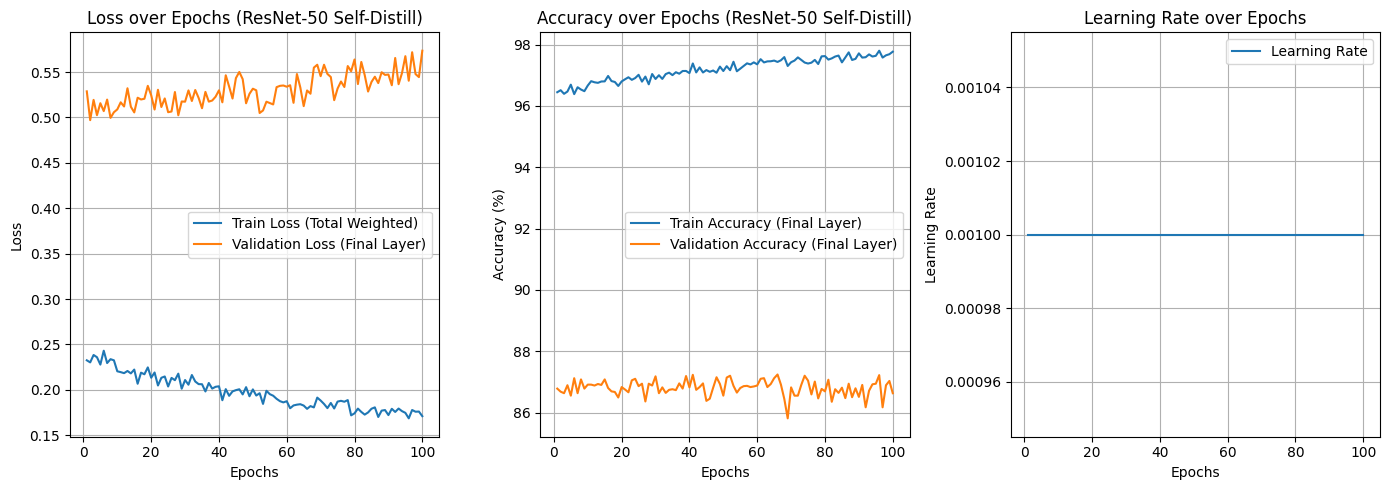

In [18]:
print("\nPlotting training history...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot Loss (Displays total weighted training loss vs final layer validation loss)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss (Total Weighted)')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss (Final Layer)')
plt.title('Loss over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy (Displays final layer training accuracy vs final layer validation accuracy)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy (Final Layer)')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy (Final Layer)')
plt.title('Accuracy over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot using the path defined in Cell 2
try:
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved to {PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot to {PLOT_SAVE_PATH}: {e}")

plt.show()

Final Test With Best Model 4

In [19]:
print("\nEvaluating the best self-distillation model on the test set...")

# --- Instantiate the ResNet50_SD architecture again ---
# Important: Instantiate the *same* custom model used for training
base_model_for_eval = torchvision.models.resnet50(weights=None) # Need the base structure again
best_model = ResNet50_SD(base_model_for_eval, num_classes=NUM_CLASSES)
# --- End of instantiation ---

try:
    # Load the best model weights saved during training (using path from Cell 2)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    best_model.to(DEVICE)
    print("Best self-distillation model weights loaded successfully.")

    # Perform final validation using the loaded best model
    # Use the specific validation function that only evaluates the final output
    final_loss, final_acc = validate_sd(best_model, testloader, criterion_ce, DEVICE)
    print(f"\nFinal Test Accuracy of the best ResNet-50 Self-Distillation model: {final_acc:.2f}%")

    # --- Compare with baseline ---
    baseline_acc = 87.68 # <-- Paste your baseline accuracy here
    print(f"Baseline ResNet-50 Test Accuracy: {baseline_acc:.2f}%")
    improvement = final_acc - baseline_acc
    print(f"Improvement due to Self-Distillation: {improvement:.2f}%")


except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Ensure training completed and saved the file.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Evaluating the best self-distillation model on the test set...
Auxiliary classifiers added after layer2 and layer3.
Best self-distillation model weights loaded successfully.
---> Validation Summary (using final output): Loss: 0.5297, Acc: 87.24%, Time: 3.55s

Final Test Accuracy of the best ResNet-50 Self-Distillation model: 87.24%
Baseline ResNet-50 Test Accuracy: 87.68%
Improvement due to Self-Distillation: -0.44%


Hyperparameter Set 5:

T=1.0

AUX weight=0.4

KL weight=0.6

In [8]:
# --- Self-Distillation Hyperparameters ---
TEMPERATURE = 1.0 # Temperature for softening probabilities
W_AUX_CE = 0.4   # Weight for auxiliary classifier Cross-Entropy losses
W_KD = 0.6     # Weight for Knowledge Distillation (KL Div) losses

Training Loop 4

In [9]:
print(f"Starting Self-Distillation Training for {EPOCHS} epochs...")
start_train_time = time.time()

best_val_acc = 0.0
# No need to initialize best_model_wts here, just save directly

# History tracking for plots (tracking total train loss and final val acc)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")
    history['lr'].append(current_lr)

    # Train for one epoch using the Self-Distillation training function
    # Pass the extra hyperparameters (temp, w_aux_ce, w_kd)
    train_loss, train_acc = train_one_epoch_sd(
        epoch, model, trainloader, optimizer, criterion_ce, criterion_kd, DEVICE,
        TEMPERATURE, W_AUX_CE, W_KD
    )

    # Validate the model using the Self-Distillation validation function
    val_loss, val_acc = validate_sd(model, testloader, criterion_ce, DEVICE)

    # Store history (Train loss is total loss, Acc is based on final layer)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc) # Final layer train acc
    history['val_loss'].append(val_loss)   # Final layer val loss
    history['val_acc'].append(val_acc)     # Final layer val acc

    # Update learning rate using the scheduler
    scheduler.step()

    # Save the best model based on validation accuracy (measured on final layer)
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved ({best_val_acc:.2f}% -> {val_acc:.2f}%). Saving model...")
        best_val_acc = val_acc
        # Save the model state dict directly to the path defined in Cell 2
        try:
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved to {MODEL_SAVE_PATH}")
        except Exception as e:
            print(f"Error saving model to {MODEL_SAVE_PATH}: {e}")


total_train_time = time.time() - start_train_time
print("\nFinished Self-Distillation Training.")
print(f"Total Training Time: {total_train_time // 60:.0f}m {total_train_time % 60:.0f}s")
print(f"Best Validation Accuracy achieved (on final layer): {best_val_acc:.2f}%")
print(f"Best model saved at: {MODEL_SAVE_PATH}")

Starting Self-Distillation Training for 100 epochs...

--- Epoch 1/100 ---
Current Learning Rate: 0.100000
Epoch [1/100], Step [97/391], Loss: 24.9505 (FinalCE: 11.3516, AuxCE: 17.8900, KD: 10.7382)
Epoch [1/100], Step [194/391], Loss: 14.8833 (FinalCE: 7.1075, AuxCE: 11.2373, KD: 5.4682)
Epoch [1/100], Step [291/391], Loss: 11.2901 (FinalCE: 5.5084, AuxCE: 8.9025, KD: 3.7011)
Epoch [1/100], Step [388/391], Loss: 9.4329 (FinalCE: 4.6575, AuxCE: 7.6980, KD: 2.8269)
Epoch [1/100], Step [391/391], Loss: 9.3902 (FinalCE: 4.6378, AuxCE: 7.6704, KD: 2.8069)
---> Epoch 1 Training Summary: Avg Loss: 9.3902, Final Acc: 16.94%, Time: 31.22s
---> Validation Summary (using final output): Loss: 2.0842, Acc: 26.61%, Time: 2.99s
Validation accuracy improved (0.00% -> 26.61%). Saving model...
Model saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/models/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6.pth

--- Epoch 2/100 ---
Current Learning Rate: 0.1000

Plotting 5


Plotting training history...
Plot saved to /content/drive/MyDrive/ECE 661 Final Project: Knowledge Distillation/A_Jerry_SelfDistillation/results/resnet50_self_distill_T3.0_Waux0.4_Wkd0.6_curves.png


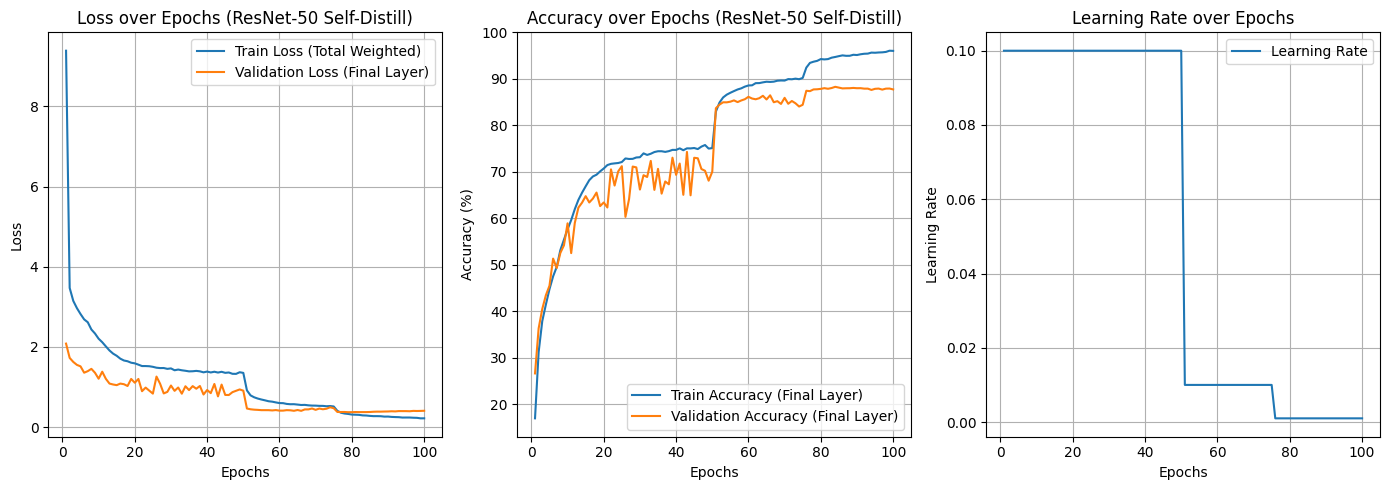

In [10]:
print("\nPlotting training history...")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Plot Loss (Displays total weighted training loss vs final layer validation loss)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss (Total Weighted)')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss (Final Layer)')
plt.title('Loss over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy (Displays final layer training accuracy vs final layer validation accuracy)
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_acc'], label='Train Accuracy (Final Layer)')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy (Final Layer)')
plt.title('Accuracy over Epochs (ResNet-50 Self-Distill)') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
# Save the plot using the path defined in Cell 2
try:
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Plot saved to {PLOT_SAVE_PATH}")
except Exception as e:
    print(f"Error saving plot to {PLOT_SAVE_PATH}: {e}")

plt.show()

Final Test With Best Model 4

In [11]:
print("\nEvaluating the best self-distillation model on the test set...")

# --- Instantiate the ResNet50_SD architecture again ---
# Important: Instantiate the *same* custom model used for training
base_model_for_eval = torchvision.models.resnet50(weights=None) # Need the base structure again
best_model = ResNet50_SD(base_model_for_eval, num_classes=NUM_CLASSES)
# --- End of instantiation ---

try:
    # Load the best model weights saved during training (using path from Cell 2)
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    best_model.to(DEVICE)
    print("Best self-distillation model weights loaded successfully.")

    # Perform final validation using the loaded best model
    # Use the specific validation function that only evaluates the final output
    final_loss, final_acc = validate_sd(best_model, testloader, criterion_ce, DEVICE)
    print(f"\nFinal Test Accuracy of the best ResNet-50 Self-Distillation model: {final_acc:.2f}%")

    # --- Compare with baseline ---
    baseline_acc = 87.68 # <-- Paste your baseline accuracy here
    print(f"Baseline ResNet-50 Test Accuracy: {baseline_acc:.2f}%")
    improvement = final_acc - baseline_acc
    print(f"Improvement due to Self-Distillation: {improvement:.2f}%")


except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_SAVE_PATH}. Ensure training completed and saved the file.")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")


Evaluating the best self-distillation model on the test set...
Auxiliary classifiers added after layer2 and layer3.
Best self-distillation model weights loaded successfully.
---> Validation Summary (using final output): Loss: 0.3763, Acc: 88.29%, Time: 2.59s

Final Test Accuracy of the best ResNet-50 Self-Distillation model: 88.29%
Baseline ResNet-50 Test Accuracy: 87.68%
Improvement due to Self-Distillation: 0.61%
